Make sure to use the virtual environment that created for this capstone project: "capstone-dev" built using `requirements.txt`.
 
Under the drop down menu options, "Kernel" -> "Capstone Development".

In [1]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import plotly.express as px
import dill
import spacy
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

## Load and preprocess data

In [62]:
jobs_path = './data/marketing_sample_for_trulia_com-real_estate__20190901_20191031__30k_data.csv'
jobs_raw = pd.read_csv(jobs_path)
jobs_raw.head()

Job Title  \
0                  Shift Manager   
1     Operations Support Manager   
2  Senior Product Manager - Data   
3     Part-Time Office Concierge   
4    Print & Marketing Associate   

                                     Job Description  Job Type  Categories  \
0  <div id="jobDescriptionText" class="jobsearch-...       NaN         NaN   
1  <div id="jobDescriptionText" class="jobsearch-...       NaN         NaN   
2  <div id="jobDescriptionText" class="jobsearch-...       NaN         NaN   
3  <div id="jobDescriptionText" class="jobsearch-...       NaN         NaN   
4  <div id="jobDescriptionText" class="jobsearch-...       NaN         NaN   

                  Location           City State        Country Zip Code  \
0  Mission Hills, CA 91345  Mission Hills    CA  United States    91345   
1        Atlanta, GA 30342        Atlanta    GA  United States    30342   
2              Chicago, IL        Chicago    IL  United States      NaN   
3               Festus, MO         Festus    MO  United States      NaN   
4   Cedar Rapids, IA 52404   Cedar Rapids    IA  United States    52404   

   Address  ...  Employer Phone  \
0      NaN  ...             NaN   
1      NaN  ...             NaN   
2      NaN  ...             NaN   
3      NaN  ...             NaN   
4      NaN  ...             NaN   

                                       Employer Logo  \
0  https://d2q79iu7y748jz.cloudfront.net/s/_squar...   
1  https://d2q79iu7y748jz.cloudfront.net/s/_logo/...   
2                                                NaN   
3                                                NaN   
4  https://d2q79iu7y748jz.cloudfront.net/s/_logo/...   

                                  Companydescription        Employer Location  \
0  Del Taco is an American quick service restaura...  Mission Hills, CA 91345   
1  Based in Atlanta, FOCUS Brands Inc. is an inno...                      NaN   
2  Vibes Corp. reputation was built and establish...                      NaN   
3                                                NaN                      NaN   
4  Staples is The Worklife Fulfillment Company, h...   Cedar Rapids, IA 52404   

   Employer City  Employer State  Employer Country Employer Zip Code  \
0  Mission Hills              CA     United States             91345   
1            NaN             NaN     United States               NaN   
2            NaN             NaN     United States               NaN   
3            NaN             NaN     United States               NaN   
4   Cedar Rapids              IA     United States             52404   

                            Uniq Id            Crawl Timestamp  
0  511f9a53920f4641d701d51d3589349f  2019-08-24 09:13:18 +0000  
1  4955daf0a3facbe2acb6c429ba394e6d  2019-09-19 08:16:55 +0000  
2  a0e0d12df1571962b785f17f43ceae12  2019-09-18 02:13:10 +0000  
3  56e411fd731f76ac916bf4fb169250e9  2019-10-24 16:39:13 +0000  
4  3fff5c0ad6981bf4bff6260bd5feab63  2019-08-24 22:29:10 +0000  

[5 rows x 30 columns]

In [63]:
jobs_raw.shape

(30002, 30)

In [64]:
jobs_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30002 entries, 0 to 30001
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Job Title           30002 non-null  object 
 1   Job Description     30002 non-null  object 
 2   Job Type            0 non-null      float64
 3   Categories          0 non-null      float64
 4   Location            30002 non-null  object 
 5   City                30002 non-null  object 
 6   State               30002 non-null  object 
 7   Country             30002 non-null  object 
 8   Zip Code            16252 non-null  object 
 9   Address             0 non-null      float64
 10  Salary From         0 non-null      float64
 11  Salary To           0 non-null      float64
 12  Salary Period       0 non-null      float64
 13  Apply Url           18392 non-null  object 
 14  Apply Email         0 non-null      float64
 15  Employees           0 non-null      float64
 16  Indu

In [6]:
print('Number of unique job posts: {}'.format(jobs_raw['Uniq Id'].nunique()))

Number of unique job posts: 30002


Since the number of unique job posts equals to the total row number, we have confirmed that each row represents a unique job post and thus we can drop the `Uniq Id` column.

In [7]:
jobs_raw['Crawl Timestamp'] = pd.to_datetime(jobs_raw['Crawl Timestamp'])

In [8]:
date_range = str(jobs_raw['Crawl Timestamp'].dt.date.min()) + ' to ' +str(jobs_raw['Crawl Timestamp'].dt.date.max())
print("The data were scraped from " + date_range)

The data were scraped from 2019-08-16 to 2019-10-25


In [65]:
columns = ['Job Title', 'Job Description', 'City', 'State', 'Country', \
           'Company Name', 'Companydescription']

jobs = jobs_raw[columns]
jobs.head()

Job Title  \
0                  Shift Manager   
1     Operations Support Manager   
2  Senior Product Manager - Data   
3     Part-Time Office Concierge   
4    Print & Marketing Associate   

                                     Job Description           City State  \
0  <div id="jobDescriptionText" class="jobsearch-...  Mission Hills    CA   
1  <div id="jobDescriptionText" class="jobsearch-...        Atlanta    GA   
2  <div id="jobDescriptionText" class="jobsearch-...        Chicago    IL   
3  <div id="jobDescriptionText" class="jobsearch-...         Festus    MO   
4  <div id="jobDescriptionText" class="jobsearch-...   Cedar Rapids    IA   

         Country                     Company Name  \
0  United States                     Del Taco LLC   
1  United States                     FOCUS Brands   
2  United States                            Vibes   
3  United States  Coldwell Banker Real Estate LLC   
4  United States                   Staples Stores   

                                  Companydescription  
0  Del Taco is an American quick service restaura...  
1  Based in Atlanta, FOCUS Brands Inc. is an inno...  
2  Vibes Corp. reputation was built and establish...  
3                                                NaN  
4  Staples is The Worklife Fulfillment Company, h...

In [66]:
jobs.shape

(30002, 7)

#### Use BeautifulSoup to extract text contents from the html elements

Extract texts under the sections titled "Job Summary", "Position Summary", "Job Functions", "Job Purpose", "Responsibilities", "Requirements", "Required", "Skills", "Qualifications", from the html content in the `Job Description` column

In [67]:
jobs['Job Description'] = jobs['Job Description'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

/tmp/ipykernel_66/671854248.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [68]:
jobs.head()

Job Title  \
0                  Shift Manager   
1     Operations Support Manager   
2  Senior Product Manager - Data   
3     Part-Time Office Concierge   
4    Print & Marketing Associate   

                                     Job Description           City State  \
0  WE ARE LOOKING FOR TOP PERFORMERS TO GROW WITH...  Mission Hills    CA   
1  \n\nJOB PURPOSE: This position is responsible ...        Atlanta    GA   
2  Product Manager - Unique opportunity with a mo...        Chicago    IL   
3  \nColdwell Banker in Festus, Missouri is looki...         Festus    MO   
4  \nDescription\nPosition Summary:\n\nThe Copy a...   Cedar Rapids    IA   

         Country                     Company Name  \
0  United States                     Del Taco LLC   
1  United States                     FOCUS Brands   
2  United States                            Vibes   
3  United States  Coldwell Banker Real Estate LLC   
4  United States                   Staples Stores   

                                  Companydescription  
0  Del Taco is an American quick service restaura...  
1  Based in Atlanta, FOCUS Brands Inc. is an inno...  
2  Vibes Corp. reputation was built and establish...  
3                                                NaN  
4  Staples is The Worklife Fulfillment Company, h...

Deal with missing values

In [69]:
jobs.isnull().sum()

Job Title                 0
Job Description           0
City                      0
State                     0
Country                   0
Company Name              2
Companydescription    10340
dtype: int64

In [14]:
# jobs.loc[jobs['Company Name'].isnull(), :]

Job Title  \
4110   Back-end Lead Application Developer   
29110      Knowledge Management Specialist   

                                         Job Description    City State  \
4110   \nJoin Our Team\n\n\nOur Company headquarters ...  Duluth    GA   
29110  \nJoin Our Team\n\n\nOur Company headquarters ...  Duluth    GA   

             Country Company Name Companydescription  
4110   United States          NaN                NaN  
29110  United States          NaN                NaN

In [15]:
# jobs = jobs.dropna(subset=['Company Name'])
# jobs.shape

(30000, 7)

Save the preprocessed dataframe to a file so that it can be used directly next time when restarting the notebook.

In [70]:
with open('jobs_preprocessed.pkd', 'wb') as f:
    dill.dump(jobs, f)

## Have a look at the job dataset

In [71]:
# Load the preprocessed data
with open('jobs_preprocessed.pkd', 'rb') as f:
    jobs = dill.load(f)

In [17]:
type(jobs)

pandas.core.frame.DataFrame

In [72]:
jobs.describe()

Job Title                                    Job Description  \
count               30002                                              30002   
unique              18077                                              24680   
top     Account Executive  By working at Sally Beauty, you would be part ...   
freq                  329                                                209   

            City  State        Country Company Name  \
count      30002  30002          30002        30000   
unique      3472     81              1        12740   
top     New York     CA  United States         Lids   
freq        1260   4495          30002          425   

                                       Companydescription  
count                                               19662  
unique                                               5786  
top     The LIDS Sports Group, operating within Hat Wo...  
freq                                                  420

Word clouds for "Job Description"

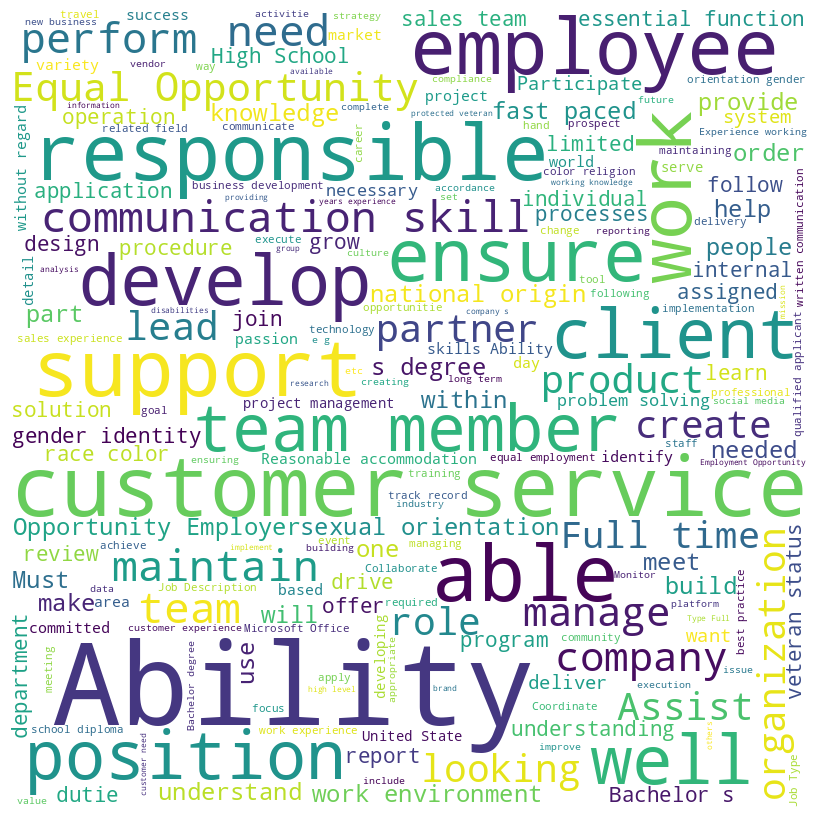

In [20]:
# Combine all the text in the "Job Description" column into a single string
text = ' '.join(jobs['Job Description'].tolist())

# Generate a word cloud from the text
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Word clouds for "Job Title"

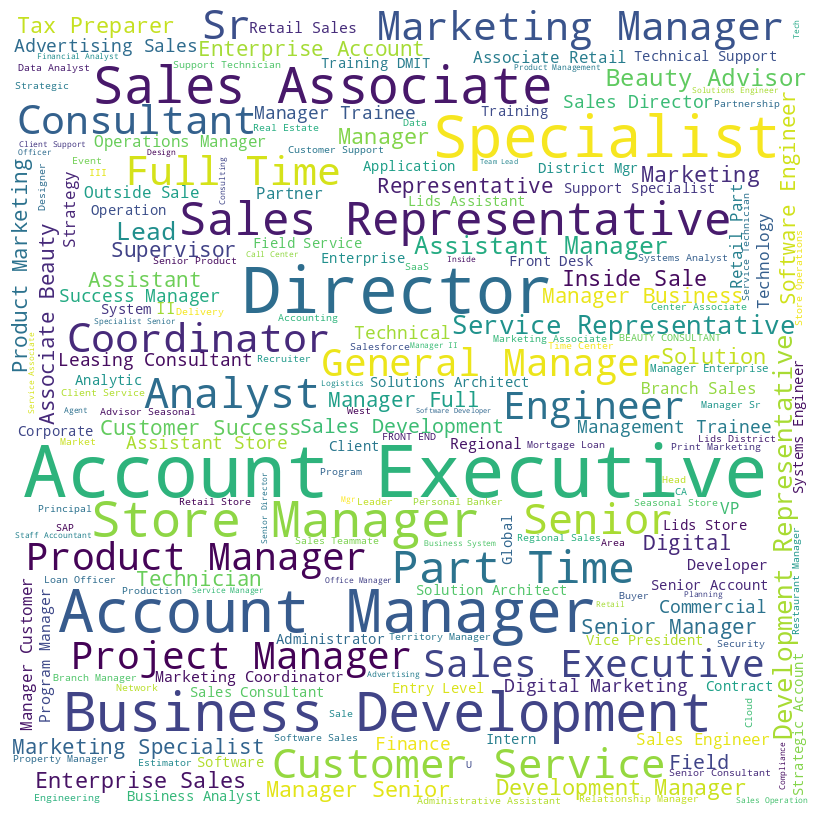

In [21]:
# Combine all the text in the "Job Title" column into a single string
text = ' '.join(jobs['Job Title'].tolist())

# Generate a word cloud from the text
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [22]:
print('Number of unique job titles: {}'.format(jobs['Job Title'].nunique()))

Number of unique job titles: 18075


In [23]:
job_title_list = jobs['Job Title'][:100].tolist()
job_title_list

/tmp/ipykernel_66/260481134.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  job_title_list = jobs['Job Title'][:100].tolist()


['Shift Manager',
 'Operations Support Manager',
 'Senior Product Manager - Data',
 'Part-Time Office Concierge',
 'Print & Marketing Associate',
 'Cyber IT Risk & Strategy Senior Consultant',
 'Sales Associate, Retail Part Time',
 'Home Lending Branch Manager-Spokane',
 'Property Manager in Training (MIT)',
 'Compliance Specialist, Marketing, Advertising & Packaging',
 'Sr. Copywriter - PHARMA',
 'Photo Booth Production Manager',
 'Sales Associate/Beauty Advisor',
 'Prog Cost/Sched Ctrl Analyst 3',
 'Tax Preparer I Store Operations',
 'Senior Software Engineer - XCHNG',
 'Internet Sales Associate',
 'Sales Associate/Beauty Advisor',
 'Business Analyst with Adobe Experience Manager (AEM) experience',
 'Omni-Channel Associate',
 'Mortgage Loan Officer - Level 2',
 'Assistant Property Manager/Leasing Consultant',
 'Store Manager (MD-Frederick Spectrum Drive)',
 'AI Solution Architect',
 'Financial Analyst',
 'Sr Pricing Analyst - CPO',
 'Electrical Engineer',
 'Account Executive - Acumat

In [24]:
jobs['Job Title'].value_counts()

Account Executive                                                              329
Sales Associate/Beauty Advisor                                                 209
Account Manager                                                                192
General Manager                                                                180
Sales Associate, Retail Part Time                                              148
                                                                              ... 
Hardware Product Manager                                                         1
Dell Technologies National Security Group Business Development Professional      1
Named Account Executive (Bachelor’s Degree & experience)                         1
Senior Director, Sales Support                                                   1
Supply Planner - Softwood Lumber (SWL)                                           1
Name: Job Title, Length: 18075, dtype: int64

In [25]:
ind = jobs['Job Title'] == 'Account Executive'
jobs[ind]

Job Title                                    Job Description  \
46     Account Executive  \nDo you spend your spare time exploring the c...   
104    Account Executive  \n\n\nAccount Executive\n\n\nCompetitive salar...   
188    Account Executive  \n\nJob Location – Hoboken, NJ – USA\nRequired...   
199    Account Executive  \n\nCompany\n\nDoxim is a leading provider of ...   
532    Account Executive  \nCherry Hill, NJ\n\nAccount Executive – Daily...   
...                  ...                                                ...   
29681  Account Executive  \nDescription of Position: \nProvide exception...   
29683  Account Executive  \nMicroRam Electronics, Inc. is a stocking dis...   
29830  Account Executive  \nSummary\nThe central mission of an Account E...   
29893  Account Executive  \nParo is seeking a self-starting Account Exec...   
29944  Account Executive  \nAs a pioneer and innovator in the IT service...   

              City State        Country                Company Name  \
46         Chicago    IL  United States                    ChefHero   
104      Hopkinton    MA  United States                        DELL   
188        Hoboken    NJ  United States                  Innoplexus   
199        Herndon    VA  United States                       Doxim   
532    Cherry Hill    NJ  United States                   Protocall   
...            ...   ...            ...                         ...   
29681  Garden City    NY  United States      Robert C. Mangi Agency   
29683      Oldsmar    FL  United States  MicroRam Electronics, Inc.   
29830  Chattanooga    TN  United States    Riverside Transport Inc.   
29893      Chicago    IL  United States                        Paro   
29944     New York    NY  United States                  Ayehu Inc.   

                                      Companydescription  
46                                                   NaN  
104     Dell Technologies is a unique family of busin...  
188    Innoplexus provides cutting-edge solutions to ...  
199                                                  NaN  
532    The Protocall Group is an independent, local, ...  
...                                                  ...  
29681                                                NaN  
29683  Established in 1991, MicroRam is an ISO9001:20...  
29830                                                NaN  
29893                                                NaN  
29944                                                NaN  

[329 rows x 7 columns]

Plot the number of job posts per state

In [26]:
# Number of job posts per state in the US, sorted by descending order
results = jobs.groupby(['State']).size().sort_values(ascending=False)
results

State
CA                4495
TX                2466
NY                2075
FL                1550
IL                1472
                  ... 
Hong                 1
South Carolina       1
Connecticut          1
Tamil                1
Sydney NSW           1
Length: 81, dtype: int64

In [27]:
# Convert panda series to dataframe
jobs_by_states = pd.DataFrame({'state':results.index, 'state_count':results.values})
jobs_by_states

state  state_count
0               CA         4495
1               TX         2466
2               NY         2075
3               FL         1550
4               IL         1472
..             ...          ...
76            Hong            1
77  South Carolina            1
78     Connecticut            1
79           Tamil            1
80      Sydney NSW            1

[81 rows x 2 columns]

In [28]:
jobs_by_states.loc[jobs_by_states['state'] == 'IL',:]

state  state_count
4    IL         1472

In [29]:
# Top 10 states for job availabilities
jobs_by_states_top = jobs_by_states[:10]
jobs_by_states_top

state  state_count
0    CA         4495
1    TX         2466
2    NY         2075
3    FL         1550
4    IL         1472
5    PA         1218
6    MA         1075
7    NC         1049
8    OH         1018
9    GA          991

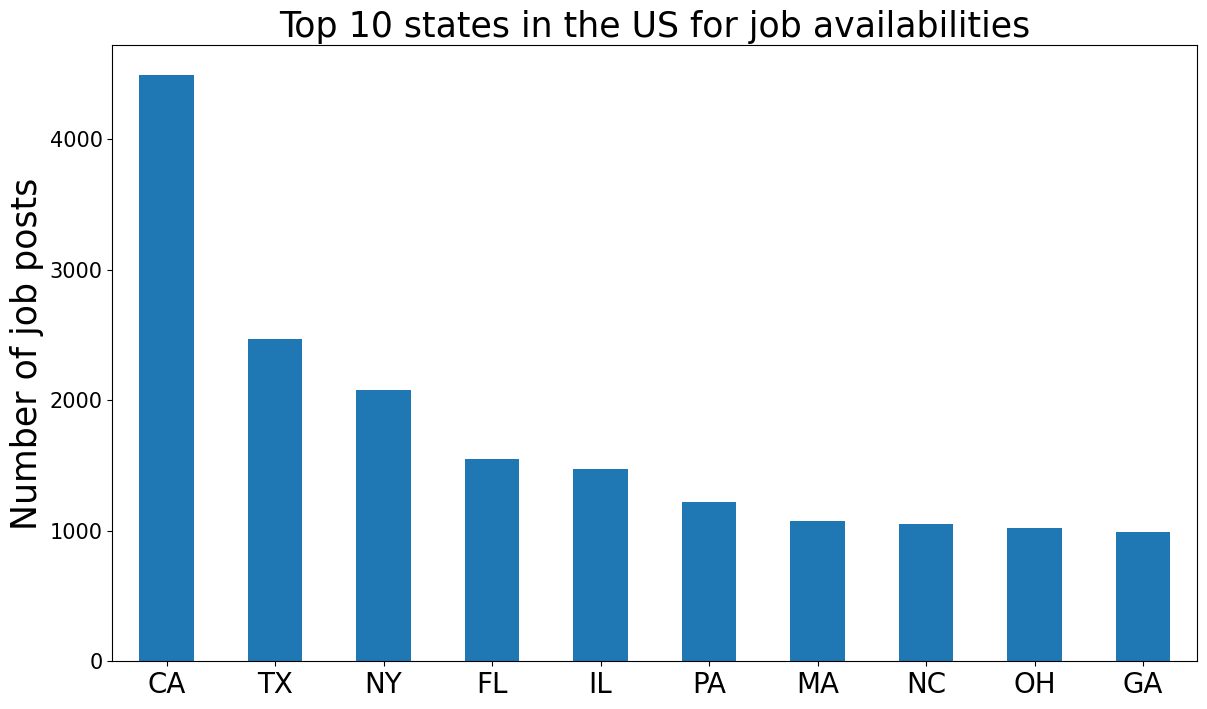

In [30]:
ax = jobs_by_states_top.plot(kind = 'bar', 
                             x='state', y='state_count',
                             figsize=(14,8))
# ax.set_xlabel("Owner Names")
ax.set_ylabel("Number of job posts", fontsize = 25)
ax.set(xlabel=None)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 15)
plt.title("Top 10 states in the US for job availabilities",
          fontsize = 25)
ax.tick_params(axis='x', labelrotation = 0)
ax.get_legend().remove()
plt.show()

In [31]:
fig = px.choropleth(jobs_by_states,
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='state_count',
                    color_continuous_scale="Oranges", #  "Viridis_r", 
                    )
fig.update_layout(
      title_text = 'Number of jobs posted per state of the US',
      title_font_family="Times New Roman",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
         )

fig.show()

## Pre-processing the text as "bag of words"

In [32]:
nlp = spacy.load('en_core_web_sm', disable=['parser','ner','textcat'])

### Engineering your features: Stop words, lemmatization, tokenization, etc

In [33]:
def my_lemmatizer(doc):
    doc_cleaned = ' '.join(re.findall(r'\b[^\d\W_][\w\']+\b', doc)) # r'\b[^\d\W_][\w\']+\b' remove words that contain only digits  r'\b\w[\w\']+\b'
    return [w.lemma_.lower() for w in nlp(doc_cleaned) 
            if w.pos_ != 'PRON' and w.lemma_ not in ['_', '.']] # remove pronouns

The following stop words were picked from eyeballing the word clouds of job descriptions. They are meaningless in determining job categories.

In [34]:
other_stop_words = {'company', 'passion', 'member', 'employee', 'able', 'well', 'responsible', 'support', 'ability',
                    'position', 'ensure', 'maintain', 'gender', 'sexual', 'orientation', 'identity', 'understand', 
                    'looking', 'equal', 'opportunity', 'perform', 'participate', 'function', 'essential', 'full', 
                    'time', 'role', 'develop', 'knowledge', 'race', 'color', 'success', 'meet', 'department', 
                    'necessary', 'provide', 'must', 'skill', 'experience', 'job','work', 'part', 'want', 'require', 
                    'requirement', 'strong', 'help', 'team', 'environment', 'develop', 'organization', 'assist', 
                    'll', 've', 'insurance', 'driver', 'license', 'com'}

In [35]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS
stopwords = stopwords.union(other_stop_words)

stopwords = set(my_lemmatizer(' '.join(sorted(stopwords))))

### Count Vectorizer & TF-IDF

In [ ]:
max_features = 8000 #1000

# tv = TfidfVectorizer(
#     tokenizer=my_lemmatizer, 
#     stop_words=list(stopwords), 
#     ngram_range = (1,1), #(1,2), 
#     min_df=2, 
#     max_df=0.95, 
#     max_features=max_features,
#     token_pattern=None
# )

# matrix = tv.fit_transform(jobs['Job Description'])

In [ ]:
## ====== Only for debugging ======
# bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
#                                     tokenizer=my_lemmatizer,
#                                     stop_words=list(stopwords))
# #                                     token_pattern=r'\b\w+\b')
# analyze = bigram_vectorizer.build_analyzer()
# txt = 'L3Harris Technologies is an agile global aerospace and defense technology innovator, delivering end-to-end solutions that meet customers‚Äô mission-critical needs. The company provides advanced defense and commercial technologies across air, land, sea, space and cyber domains. L3Harris has approximately $17 billion in annual revenue, 50,000 employees and customers in more than 130 countries . L3Harris. com'
# analyze(txt) # == (['bi', 'grams', 'are', 'cool', 'bi grams', 'grams are', 'are cool'])

In [ ]:
# with open('tv_mat.pkd', 'wb') as f:
#     dill.dump(matrix, f)
    
# with open('tv.pkd', 'wb') as f:
#     dill.dump(tv, f)

In [36]:
# Load the preprocessed data
with open('tv_mat.pkd', 'rb') as f:
    matrix = dill.load(f)
    
with open('tv.pkd', 'rb') as f:
    tv = dill.load(f)

## $K$-means clustering 

In [37]:
from sklearn.cluster import KMeans

In [38]:
number_of_clusters = 36

kmc = KMeans(n_clusters=number_of_clusters, n_init=3, random_state=137)  # random_state for consistency
kmc.fit(matrix)

KMeans(n_clusters=36, n_init=3, random_state=137)

Once we have the clustering, next find the "representative" for each cluster.

The `cluster_centers_` attribute of the clustering gives us the coordinates of each center of the clusters.  

In [39]:
kmc_centers = kmc.cluster_centers_
kmc_centers

array([[0.02186006, 0.00224783, 0.00133233, ..., 0.00407188, 0.        ,
        0.00068128],
       [0.06361325, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01937358, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00863322, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02207475, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01129625, 0.        , 0.00015041, ..., 0.        , 0.        ,
        0.        ]])

In [40]:
kmc_centers.shape

(36, 8000)

In [41]:
np.amax(kmc_centers, axis=1)

array([0.26254356, 0.56156818, 0.16550197, 0.20167976, 0.5821715 ,
       0.41985976, 0.08978993, 0.46019955, 0.51482482, 0.52805158,
       0.23850539, 0.12666471, 0.10931197, 0.14194893, 0.27244453,
       0.24948077, 0.23117198, 0.33436105, 0.03391136, 0.2324387 ,
       0.25963683, 0.55035739, 0.06557779, 0.27657426, 0.40344975,
       0.09873488, 0.67724349, 0.10756794, 0.38379366, 0.05536957,
       0.31865646, 0.22560985, 0.47594392, 0.33617511, 0.24420493,
       0.14444926])

In [42]:
number_of_top_words = 20

cluster_words = np.argsort(kmc_centers, axis=1) # sort by ascending order
terms = tv.get_feature_names_out() 

top_words = set()

for i in range(number_of_clusters):
    print(f'Cluster {i}: ')
    print(', '.join([terms[k] for k in cluster_words[i][-number_of_top_words:]]),'\n')
    top_words = top_words.union([terms[k] for k in cluster_words[i][-number_of_top_words:]])
    
top_words = sorted(list(top_words))

Cluster 0: 
technology, financial, year, marketing, include, development, industry, product, need, manage, project, new, customer, relationship, management, solution, service, business, account, client 

Cluster 1: 
process, create, need, solution, product, tool, activity, client, service, effective, manage, loyalty, wallet, identify, financial, risk, banking, branch, customer, pnc 

Cluster 2: 
applicable, shift, beauty, protect, welcome, law, service, prestige, jcpenney, previous, standard, status, applicant, associate, achieve, inspirational, jcp, customer, retail, store 

Cluster 3: 
problem, request, office, follow, high, management, issue, information, business, process, include, bank, duty, need, branch, account, product, order, service, customer 

Cluster 4: 
complimentary, event, sample, cosmetic, care, walgreen, skin, working, occasionally, advisor, store, inform, loyalty, product, passionate, recur, customer, hair, sally, beauty 

Cluster 5: 
consistent, dmit, adhere, operat

### Evaluate the clustering results

How many documents (job posts) are in each cluster?

In [43]:
cluster_df = pd.DataFrame(kmc.labels_.tolist(), columns=['Cluster'])
cluster_df.head()

Cluster
0       24
1       24
2       12
3        3
4       34

In [44]:
cluster_df['Cluster'] = cluster_df['Cluster'].astype('category')
cluster_df_agg = cluster_df.groupby('Cluster').size().reset_index(name='count')
cluster_df_agg['proportion'] = cluster_df_agg['count']/cluster_df_agg['count'].sum()
cluster_df_agg

Cluster  count  proportion
0        0   1187    0.039564
1        1    334    0.011133
2        2    306    0.010199
3        3   1576    0.052530
4        4    299    0.009966
5        5    581    0.019365
6        6    516    0.017199
7        7    315    0.010499
8        8    384    0.012799
9        9    271    0.009033
10      10    582    0.019399
11      11   1219    0.040631
12      12   1459    0.048630
13      13    948    0.031598
14      14    729    0.024298
15      15    161    0.005366
16      16    147    0.004900
17      17    546    0.018199
18      18   4108    0.136924
19      19    287    0.009566
20      20   1465    0.048830
21      21    344    0.011466
22      22   1874    0.062463
23      23   1027    0.034231
24      24    376    0.012532
25      25   2726    0.090861
26      26     70    0.002333
27      27   1678    0.055930
28      28    303    0.010099
29      29   1845    0.061496
30      30    683    0.022765
31      31    451    0.015032
32      32    162    0.005400
33      33    371    0.012366
34      34    194    0.006466
35      35    478    0.015932

In [45]:
sum(cluster_df_agg['count']) # sanity check

30002

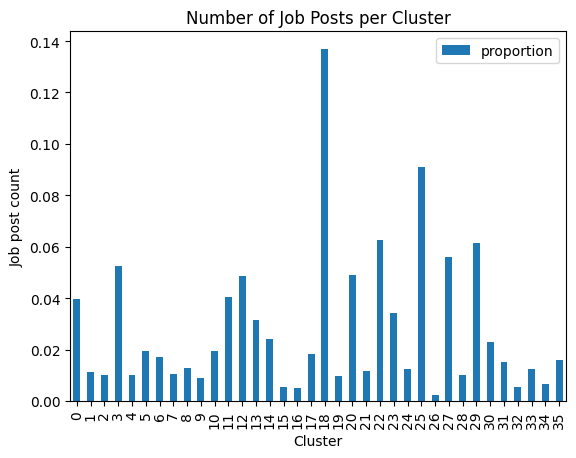

In [46]:
cluster_df_agg.\
    plot.bar(x = 'Cluster', y = 'proportion', rot=90).\
    set(ylabel='Job post count',
    title='Number of Job Posts per Cluster');

Retrieve the original job posts given a cluster 

In [74]:
# Add `Cluster` as an additional column to the job post dataframe
jobs['Cluster'] = kmc.labels_.tolist()

In [75]:
jobs.loc[29993,:]

Job Title                                         Senior Tax Accountant
Job Description       \nPosition:  Senior Tax Accountant\nDescriptio...
City                                                         Washington
State                                                                DC
Country                                                   United States
Company Name                                        SPS Consulting, LLC
Companydescription                                                  NaN
Cluster                                                              21
Name: 29993, dtype: object

In [76]:
jobs.loc[13,:]

Job Title                                Prog Cost/Sched Ctrl Analyst 3
Job Description       \n\n\nL3Harris is dedicated to recruiting and ...
City                                                             Folsom
State                                                                CA
Country                                                   United States
Company Name                                            L3 Technologies
Companydescription    Headquartered in New York City, L3 Technologie...
Cluster                                                              18
Name: 13, dtype: object

In [77]:
jobs.loc[11,:]

Job Title                                Photo Booth Production Manager
Job Description       \nOur SMF team is looking for a Production Man...
City                                                         Sacramento
State                                                                CA
Country                                                   United States
Company Name                                      The Photo Booth Squad
Companydescription                                                  NaN
Cluster                                                              29
Name: 11, dtype: object

In [78]:
jobs.loc[8,:]

Job Title                            Property Manager in Training (MIT)
Job Description       \nOverview\n\n\n\n\nJob Location\nDurham, NC -...
City                                                             Durham
State                                                                NC
Country                                                   United States
Company Name                                         PRG Real Estate PA
Companydescription                                                  NaN
Cluster                                                              17
Name: 8, dtype: object

In [79]:
ind = jobs['Cluster']==17
jobs.loc[ind, 'Job Title']

8                   Property Manager in Training (MIT)
21       Assistant Property Manager/Leasing Consultant
38                                  Leasing Consultant
155                                Move-in Coordinator
166                       Part-Time Leasing Consultant
                             ...                      
29813                       Apartment Property Manager
29829         Leasing Consultant - Apartment Community
29840                               LEASING CONSULTANT
29874                     Apartment Leasing Consultant
29889          Assistant Resident and Property Manager
Name: Job Title, Length: 546, dtype: object

In [80]:
ind = jobs['Cluster']==18
jobs.loc[ind, 'Job Title']

9        Compliance Specialist, Marketing, Advertising ...
10                                 Sr. Copywriter - PHARMA
13                          Prog Cost/Sched Ctrl Analyst 3
60           Education Expert - Westfarms Mall (Full-Time)
67          Business Development Executive - Food Services
                               ...                        
29949                Regional Business Development Manager
29956             DEVELOPMENT REPRESENTATIVE II - 42001323
29970             Unit Human Resources Manager - LifeWorks
29975       Enterprise Business Development Representative
29991                           Non Profit Org Coordinator
Name: Job Title, Length: 4108, dtype: object

Print a portion of the job titles and row indices of the job posts in each cluster. They can be used to retrieve the original job post from the dataset (the csv file).

In [81]:
selected_cluster_number = [22,15,24, 3, 23, 18, 22, 27, 12, 6, 28, 18, 12, 27, 0, 7, 18, 12, 0, 10]
selected_cluster_number = sorted(set(selected_cluster_number))

for _, cluster in enumerate(selected_cluster_number):
    print(f'Cluster: {cluster}\n')
    print(jobs.loc[jobs['Cluster']==cluster, 'Job Title'].head(20))
    print('\n')

Cluster: 0

5             Cyber IT Risk & Strategy Senior Consultant
27     Account Executive - Acumatica Cloud ERP US Bas...
62     Commercial Relationship Manager, VP or SVP - M...
77                Manufacturing Consulting Market Leader
113    Sr. Security Consultant - PCI Qualified Securi...
143                             New Business Development
177                                     Research Manager
182                              Sales Account Executive
190                                  Performance Manager
196                                    Financial Planner
199                                    Account Executive
205                 Account Executive III- Charlotte, NC
253                                Advertising Assistant
291                                        Event Manager
363                Senior Government Pharmacy Consultant
429                           Client Strategy Consultant
430    Marketing Account Coordinator/Marketing Accoun...
470                

### Choosing the number of clusters

In [82]:
from sklearn.metrics import silhouette_score

In [84]:
# number_of_clusters_seq = range(5, 50, 2)
# sil_score = [None] * len(number_of_clusters_seq)

# for i, number_of_clusters in enumerate(number_of_clusters_seq):
#     print(f'Start computing n_clusters = {number_of_clusters} ...')
#     kmc = KMeans(n_clusters=number_of_clusters, n_init=3, random_state=137)  
#     kmc.fit(matrix)
#     sil_score[i] = silhouette_score(matrix, kmc.labels_.tolist())

In [ ]:
# df_cluster_sil = pd.DataFrame({'number of clusters': number_of_clusters_seq, 'Silhouette score': sil_score})
# df_cluster_sil

In [ ]:
# with open('sil_scores_4_tv_mat.pkd', 'wb') as f:
#     dill.dump(df_cluster_sil, f)

In [85]:
with open('sil_scores_4_tv_mat.pkd', 'rb') as f:
    df_cluster_sil = dill.load(f)

<AxesSubplot: xlabel='number of clusters'>

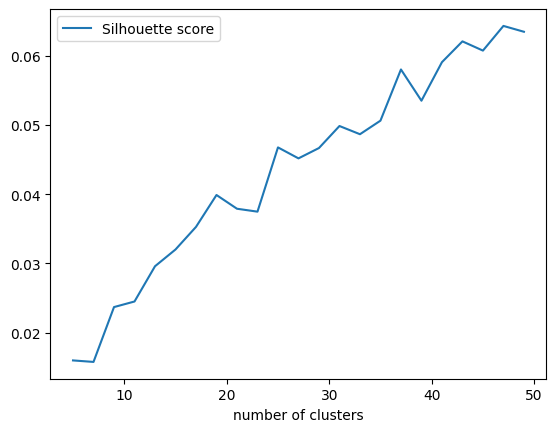

In [86]:
df_cluster_sil.plot(x='number of clusters', y='Silhouette score')

Plot the top word frequency in each cluster. The goad is to detect the words that are common in most clusters. These words then can be added to stopwords and rerun the preprocessing and the analysis.

In [88]:
# word_df = pd.DataFrame(matrix.toarray(), columns=terms)[top_words]
# word_df['Cluster'] = kmc.labels_.tolist()

In [ ]:
# word_df

In [ ]:
# word_df_agg = word_df.groupby('Cluster').sum()
# word_df_agg

In [ ]:
# word_df_agg_sub = word_df_agg.iloc[:, 21:40] # choose a subset of words
# word_df_agg_sub.transpose().\
#     plot.bar(figsize=(13,5), width=0.7).\
#     set(ylabel='Word frequency', 
#     title=f'Word Frequencies by Topic, Combining the Top {number_of_top_words} Words in Each Topic');

Project the clusters on lower dimensions

In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2, random_state=117)
# matrix_pca = pca.fit_transform(matrix.toarray())

# matrix_pca.shape

## Compute similarity between the resume and each of the job categories

Convert the user-uploaded pdf document into a vector representation which is in the same format as the representations of our job categories.

In [89]:
resume_path = './data/Resume.csv' # a dataset of sample resumes downloaded from Kaggle
resume = pd.read_csv(resume_path)
resume.head()

ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR

In [90]:
resume.shape

(2484, 4)

In [91]:
resume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


In [92]:
resume['Category'].unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [93]:
resume_chef = resume[resume['Category'] == 'CHEF']
resume_chef.head()

ID                                         Resume_str  \
1357  15180322           CHEF       Career Focus     I am a nu...   
1358  24221960           CHEF           Summary     Customer-o...   
1359  24673903           CHEF           Career Overview     De...   
1360  19007667           CHEF       Summary     Experienced ca...   
1361  30311202          RM     Roxanne    Mejia       Summary ...   

                                            Resume_html Category  
1357  <div class="fontsize fontface vmargins hmargin...     CHEF  
1358  <div class="fontsize fontface vmargins hmargin...     CHEF  
1359  <div class="fontsize fontface vmargins hmargin...     CHEF  
1360  <div class="fontsize fontface vmargins hmargin...     CHEF  
1361  <div class="RNA skn-mng3 fontsize fontface vma...     CHEF

In [94]:
resume_chef_sample_text = resume.loc[resume['ID'] == 24221960, 'Resume_str'].tolist()[0]
resume_chef_sample_text

"         CHEF           Summary     Customer-oriented fast food worker with deep experience with POS systems, food preparation and safety regulations. I am highly efficient at preparing food orders quickly while greeting all customers and managing the cash register accurately.Adaptable warehouse picker with extensive experience in material handling, inspections and shipping and receiving. Focused on continual process improvement and cost reduction. I am also familiar with all aspects of logistics, shipping and receiving and general warehouse operations.       Highlights                Fast learner Friendly Communication Skills Computer Skills Customer Service Skills Leadership Skills Organizational Skills Research and Planning Skills Interpersonal Skills Safety-oriented Neat, clean and professional appearance Comfortable standing for long time periods Shipping and receiving skills Reliable and punctual                 Accomplishments     Obtaining Raises at previous Jobs and working i

In [95]:
resume_teacher_sample_text = resume.loc[resume['ID'] == 10504237, 'Resume_str'].tolist()[0]
resume_teacher_sample_text

"         BIOLOGY TEACHER           Experience     11/2016   to   Current     Biology Teacher    Company Name   －   City  ,   State      Execute, implement, and modify lesson plans while incorporating differentiated instruction and multiple intelligences.  Design and align lessons, labs, and assessments incorporating STEM, problem based learning, Common Core and NGSS.  Volunteer and participate in schools extracurricular activities such as selling tickets for the school talent show and participating in the Lindenwold HS 5K for the scholarship fund.  Teach and translate materials utilizing Sheltered Instruction techniques for English Language Learners.  Co-teach with special education teachers while executing modifications in student IEP and 504 plans.  Plan and present Google applications training for Lindenwold HS professional development.         09/2011   to   11/2016     Biology Teacher    Company Name   －   City  ,   State      Seek out of district professional development opportu

In [96]:
resume_health = resume[resume['Category'] == 'HEALTHCARE']
resume_health.head()

ID                                         Resume_str  \
677  23617240           HEALTHCARE           Executive Profil...   
678  23138078           HEALTHCARE ADMINISTRATOR       Profes...   
679  51777546           HEALTHCARE RECRUITER         Highligh...   
680  69199666        G        HEALTHCARE RECRUITER           ...   
681  93988900           HEALTHCARE CONSULTANT       Executive...   

                                           Resume_html    Category  
677  <div class="fontsize fontface vmargins hmargin...  HEALTHCARE  
678  <div class="fontsize fontface vmargins hmargin...  HEALTHCARE  
679  <div class="fontsize fontface vmargins hmargin...  HEALTHCARE  
680  <div class="fontsize fontface vmargins hmargin...  HEALTHCARE  
681  <div class="fontsize fontface vmargins hmargin...  HEALTHCARE

In [97]:
resume_health_sample_text = resume_health.loc[677, 'Resume_str']
resume_health_sample_text

'         HEALTHCARE           Executive Profile    Cynthia was also an instructor for the Cap Gemini Ernst & Young Global Regulatory Compliance Boot Camp where members of the CGE&Y Regulatory Compliance Team are immersed in global regulatory compliance, Good Manufacturing Practices, Good Clinical Practices, Good Laboratory Practices, CGE&Y validation tools and methodology.  Working with the international workforce of CGE&Y, Cynthia was required to be flexible, sensitive and creative in her methods of teaching   \nCynthia\'s nursing career focus was in Pain Management, Emergency Nursing, Legal Nurse Consulting and Life Care Planning. She has traveled extensively throughout the U. S. and worldwide as a Health Care and Life Sciences Consultant for G Major Consulting, Cap Gemini Ernst & Young, Accenture, and Ness Technologies. \nWhile working in clinical nursing, Cynthia worked in acute, home care and long term care arenas. As a Case Manager and Life Care Planner Cynthia was an adjunct in

In [98]:
resume_banking = resume[resume['Category'] == 'BANKING']
resume_banking.head()

ID                                         Resume_str  \
2149  74552449           BANKING         Summary     Hands-on,...   
2150  79041971           BANKING           Summary    High-ene...   
2151  77156708           BANKING OFFICER         Professional ...   
2152  24580361           ASSOCIATE, INVESTMENT BANKING OPERATI...   
2153  34953092           CORPORATE BANKING ASSISTANT, INTERN  ...   

                                            Resume_html Category  
2149  <div class="fontsize fontface vmargins hmargin...  BANKING  
2150  <div class="fontsize fontface vmargins hmargin...  BANKING  
2151  <div class="MPR skn-cbg1 fontsize fontface vma...  BANKING  
2152  <div class="fontsize fontface vmargins hmargin...  BANKING  
2153  <div class="fontsize fontface vmargins hmargin...  BANKING

In [99]:
resume_banking_sample_text = resume_banking.loc[2152, 'Resume_str']
resume_banking_sample_text

"         ASSOCIATE, INVESTMENT BANKING OPERATIONS         Highlights          Proficient\nin Microsoft Office (Excel, PowerPoint, Word, Access), Minitab, Maple, Lingo,\nand HTML Applications  Experience\nin SAP programs as well as Six Sigma      Detail-oriented  Analytical\u200b  Troubleshooting and problem solving  Superior\ncommunication, group dynamic, time management, organizational and leadership\nskills            Experience      Associate, Investment Banking Operations   07/2013       Company Name     City  ,   State             Intern, Syndicated Loan Operations   06/2012   －   12/2012     Company Name     City  ,   State     Responsible\nfor performing maintenance on over 150 deals with over 1000 loans, including\nprocessing notices of loan activity, managing cash flows, and monitoring past\ndues and exceptions. Identified issues and partnered with the agent banks to\ndefine the root cause and implement a remediation plan. Prepared and distributed\nweekly status updates to th

In [100]:
def cos_similarity(row1, row2):
    # Since they'll both be 1 X N, we need to Transpose one of them
    # The result is a 1x1, we get the value with [0, 0]
    dot = np.dot(row1, row2.T)
    len1 = np.sqrt(np.dot(row1, row1.T))
    len2 = np.sqrt(np.dot(row2, row2.T))
    return dot / len1 / len2

In [101]:
def match_res_to_jobs(resume_sample_text, cluster_centers, top_5_clusters = True, showID = True):
    resume_vec = tv.transform([resume_sample_text])
    resume_vec = resume_vec.toarray()
    
    n_clusters = len(cluster_centers)
    similarity = [None] * n_clusters
    
    for i in range(n_clusters):
        similarity[i] = cos_similarity(resume_vec[0], cluster_centers[i])
        
    df = pd.DataFrame({'Job Category': range(n_clusters), 
                       'Your matching score': similarity,
                       'Job availability': cluster_df_agg['proportion']
                       })
#     df['Job Category'] = df['Job Category'].astype('object')
#     df = df.set_index(['Job Category'])
    df = df.sort_values(by=['Your matching score'], ascending=False)
    # Reset the index of the sorted DataFrame
    df = df.reset_index(drop=True)
    
    if top_5_clusters:
        df = df.head(5)
    
    ## ====== Plot ======
#     axes = df.head(5).plot.bar(rot=0, subplots=True, title=['', ''], 
#                                   color={"Your matching score": "red", "Job category popularity": "green"})

#     # axes[1].legend()  #loc=2
#     axes[0].set_ylim([0, 0.4])
#     axes[1].set_ylim([0, 0.15])

    # Create a figure and a set of subplots with a custom size
    if top_5_clusters:
        fig_w = 4 # in inches
        fig_h = 6
    else:
        fig_w = 8 # in inches
        fig_h = 6
        
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))  # Adjust width and height as needed

    # Plotting bars pointing upwards (B column)
    ax.bar(df.index, df['Your matching score'], color='green', align='center', alpha=0.7)

    # Plotting bars pointing downwards (C column)
    ax.bar(df.index, -df['Job availability'], color='orange', align='center', alpha=0.7)
    
    if showID:
        # Adding labels to the bars
        for i, (b, c, label) in enumerate(zip(df['Your matching score'], df['Job availability'], df['Job Category'])):
            ax.text(i, -c - 0.01, f"ID = {label}", ha='center', va='top', fontsize=10, rotation=90)


#     # Adding labels and title
#     ax.set_xlabel('')
#     ax.set_ylabel('Values')
#     ax.set_title('Bar Plot with Positive and Negative Bars')

    # Adding a legend
    ax.legend(['Your matching score', 'Job availability'])

    ## ------ Display the plot ------
    # Removing spines (bounding box) around the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.xticks([])  # Hide x-axis ticks and labels
    
    # Adjusting y-axis ticks to represent both positive and negative values
    ticks = [-0.15, -0.10, -0.05, 0.00, 0.10, 0.20, 0.30]
    tick_labels = ['0.15', '0.10', '0.05', '0.00', '0.10', '0.20', '0.30']
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)

    plt.show()

    
    return df

/home/jovyan/capstone/capstone-dev/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.



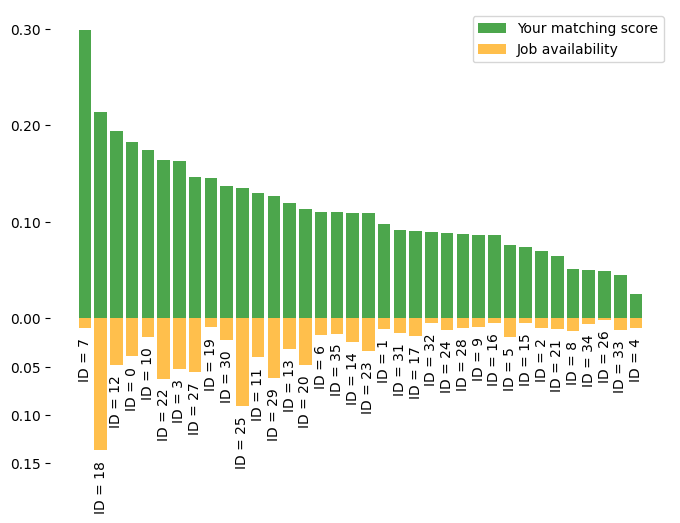

In [102]:
result_df = match_res_to_jobs(resume_banking_sample_text, kmc_centers, top_5_clusters = False, showID = True)

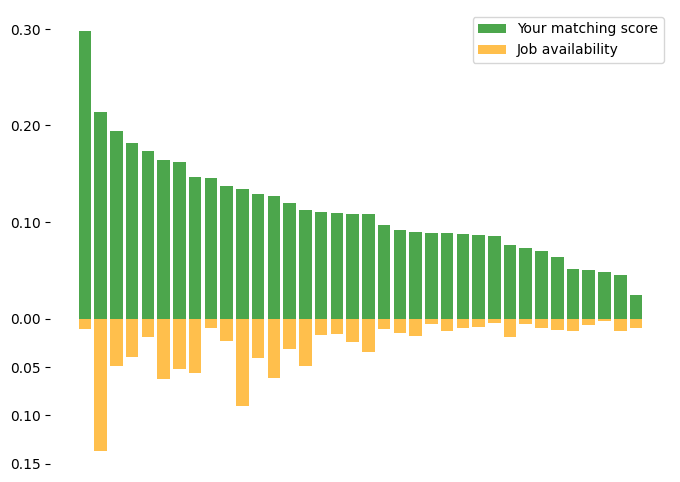

In [103]:
result_df = match_res_to_jobs(resume_banking_sample_text, kmc_centers, top_5_clusters = False, showID = False)

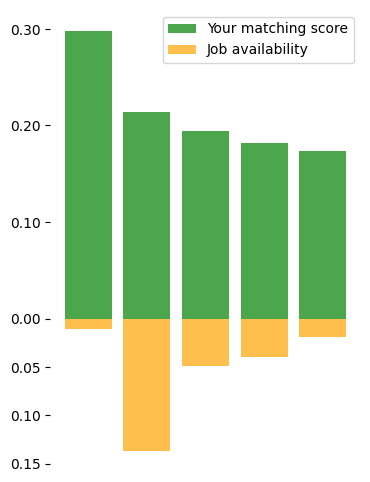

In [104]:
result_df = match_res_to_jobs(resume_banking_sample_text, kmc_centers, top_5_clusters = True, showID = False)

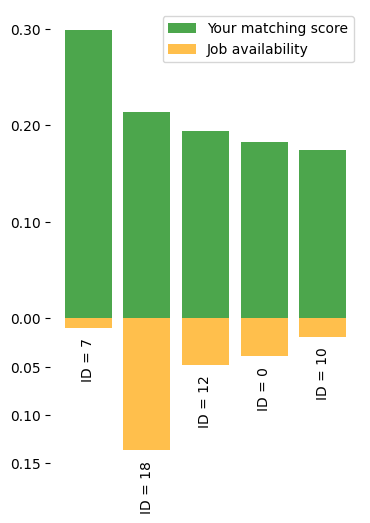

In [105]:
result_df = match_res_to_jobs(resume_banking_sample_text, kmc_centers)

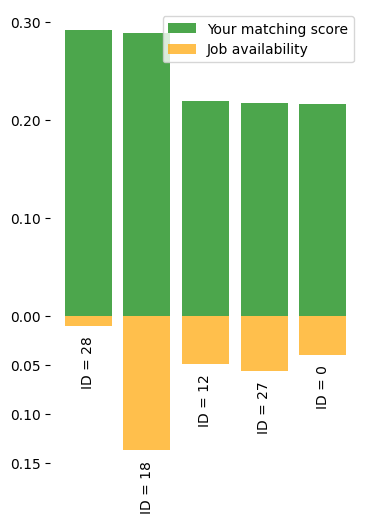

In [106]:
result_df = match_res_to_jobs(resume_health_sample_text, kmc_centers)

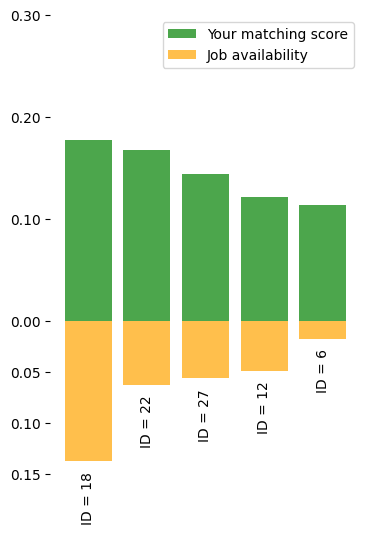

In [107]:
result_df = match_res_to_jobs(resume_teacher_sample_text, kmc_centers)

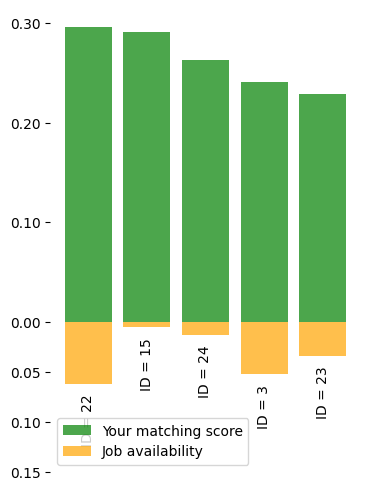

In [108]:
result_df = match_res_to_jobs(resume_chef_sample_text, kmc_centers)

## Problems remain

* Dataset is imbalanced across different job categories/job titles
* Use context-based NLP models (e.g. Word2Vec) to preprocess the job postings.
* Build a web application using Streamlit